In [1]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random

from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

Declare data directories and read files
--------------------------------------

In [3]:
#Trigger lines
'''trigger_lines = ['Hlt1GlobalDecision==1',
'Hlt1DiMuonHighMassDecision==1',
'Hlt1TrackMVADecision==1', 
'Hlt1TwoTrackMVADecision==1', 
'HLT1TrackMuonMVADecision==1',
'L0PhysicsDecision==1',
'L0MuonDecision==1',
'L0DiMuonDecision==1',
'L0MuonHighDecision==1',
'L0HadronDecision==1',
'L0ElectronDecision==1',
'L0PhotonDecision==1',
'Hlt2GlobalDecision==1',
'Hlt2DiMuonJPsiDecision==1',
'Hlt2DiMuonDetachedJPsiDecision==1']'''

trigger_lines = '(B0_L0MuonDecision_Dec==1)|(B0_Hlt1TrackMuonDecision_Dec==1)|(B0_Hlt2DiMuonJPsiDecision_Dec==1)'

In [4]:
#directories and files 
data_dir_2015 = '/fhgfs/users/chasenberg/data/2015/jpsiks/flattened/'
data_file_2015 ='Bd2JpsiKS_data_2015_flattened.root'
data_dir_2016 = '/fhgfs/users/chasenberg/data/2016/jpsiks/flattened/'
data_file_2016 ='Bd2JpsiKS_data_2016_flattened.root'

mc_dir = '/fhgfs/users/chasenberg/mc/2016/jpsiks/dimuon/flattened/'
mc_file = 'Bd2JpsiKS_dimuon_mc_2016_flat.root'

data_dir_2015 = os.path.join(data_dir_2015, data_file_2015)
data_dir_2016 = os.path.join(data_dir_2016, data_file_2016)
mc_dir = os.path.join(mc_dir, mc_file)

In [5]:
#Treename and cut for data
tree_data = 'Bd2JpsiKs'
cut_string_data = 'B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M<5450&B0_FitDaughtersConst_M>5220&(B0_L0MuonDecision_Dec==1|B0_Hlt1TrackMuonDecision_Dec==1|B0_Hlt2DiMuonJPsiDecision_Dec==1)'
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M<5450&B0_FitDaughtersConst_M>5220&B0_BKGCAT==0&(B0_L0MuonDecision_Dec==1|B0_Hlt1TrackMuonDecision_Dec==1|B0_Hlt2DiMuonJPsiDecision_Dec==1)'
tree_mc = 'Bd2JpsiKs'

Names of variables used in this selection


In [6]:
variables = [
'B0_M',
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',    
'B0_TAU',
'B0_TAUERR',
'B0_FitDaughtersConst_M',
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_L0MuonDecision_Dec',
'B0_Hlt1TrackMuonDecision_Dec',
'B0_Hlt2DiMuonJPsiDecision_Dec',
'B0_M',
'idxPV',
'piminus_TRACK_Type',
'B0_FitPVConst_status',
'B0_FitDaughtersConst_KS0_P1_PT', 
'B0_FitDaughtersConst_KS0_P0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_P0_PT', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT',
'B0_FitPVConst_KS0_tau',
'B0_FitPVConst_KS0_tauErr',
#'SigYield_sw',
#'BkgYield_sw'    
]
variables_mc = [
'B0_M',
'B0_FitDaughtersConst_M',
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_L0MuonDecision_Dec',
'B0_Hlt1TrackMuonDecision_Dec',
'B0_Hlt2DiMuonJPsiDecision_Dec',
'B0_M',
'idxPV',
'piminus_TRACK_Type',
'B0_FitPVConst_status',
'B0_FitDaughtersConst_KS0_P1_PT', 
'B0_FitDaughtersConst_KS0_P0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_P0_PT', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT',
'B0_FitPVConst_KS0_tau',
'B0_FitPVConst_KS0_tauErr',
'B0_BKGCAT'
]

In [7]:
#read root files
#2015 sideband
real_dataframe_2015 = rp.read_root(data_dir_2015,key=tree_data, columns=variables,where=cut_string_data, flatten=True)
real_dataframe_2015 = real_dataframe_2015.replace([np.inf, -np.inf], np.nan)
real_dataframe_2015 = real_dataframe_2015.dropna()
#2016 sideband
real_dataframe_2016 = rp.read_root(data_dir_2016,key=tree_data ,columns=variables,where=cut_string_data, flatten=True)
real_dataframe_2016 = real_dataframe_2016.replace([np.inf, -np.inf], np.nan)
real_dataframe_2016 = real_dataframe_2016.dropna()

signal_dataframe = rp.read_root(mc_dir,key=tree_mc,columns=variables_mc,where=cut_string_mc, flatten=True)
signal_dataframe = signal_dataframe.replace([np.inf, -np.inf], np.nan)
signal_dataframe = signal_dataframe.dropna()

In [8]:
real_dataframe_2015.shape,real_dataframe_2016.shape

((455733, 27), (2067373, 27))

In [9]:
real_dataframe = pd.concat([real_dataframe_2015,real_dataframe_2016])

Generate new features
------------------------------------

In [10]:
#add symmetrical variables to dataframe
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(real_dataframe, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])
add_min_to_dataframe(signal_dataframe, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])

#choose minimal value of both pions ipchi2
add_min_to_dataframe(real_dataframe, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])
add_min_to_dataframe(signal_dataframe, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(real_dataframe, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])
add_min_to_dataframe(signal_dataframe, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])

#Generate dimensionless decay-time distribution
real_dataframe['B0_FitPVConst_KS0_tau_dimless'] = real_dataframe['B0_FitPVConst_KS0_tau']/real_dataframe['B0_FitPVConst_KS0_tauErr']
signal_dataframe['B0_FitPVConst_KS0_tau_dimless'] = signal_dataframe['B0_FitPVConst_KS0_tau']/signal_dataframe['B0_FitPVConst_KS0_tauErr']

In [11]:
#del signal_dataframe['B0_BKGCAT']
del signal_dataframe['__array_index']
#Just a check
signal_dataframe.shape, real_dataframe.shape 

((594970, 27), (2523106, 31))

In [12]:
real_dataframe.head(n=5)

,B0_M,B0_TAGDECISION_OS,B0_TAGOMEGA_OS,B0_TAU,B0_TAUERR,B0_FitDaughtersConst_M,B0_FitDaughtersConst_chi2,B0_FitDaughtersConst_IPCHI2,B0_FitDaughtersConst_J_psi_1S_IP,B0_FitDaughtersConst_KS0_P1_PT,...,B0_FitDaughtersConst_KS0_P1_IPCHI2,B0_FitDaughtersConst_J_psi_1S_P0_PT,B0_FitDaughtersConst_J_psi_1S_P1_PT,B0_FitPVConst_KS0_tau,B0_FitPVConst_KS0_tauErr,__array_index,B0_FitDaughtersConst_KS0_min_PT,test_IP,B0_FitDaughtersConst_J_psi_1S_min_PT,B0_FitPVConst_KS0_tau_dimless
0,5358.216868,0,0.5,0.001888,0.000051,5355.345215,26.257616,128.751755,0.130379,544.952942,...,1936.826416,521.928589,4603.533691,0.011053,0.000141,0,478.590851,1936.826416,521.928589,78.671333
1,5358.216868,0,0.5,0.001888,0.000051,5355.345215,26.257616,3220.874023,0.915294,544.952942,...,1477.915039,521.928589,4603.533691,0.011496,0.000143,1,478.590851,1477.915039,521.928589,80.503784
2,5358.216868,0,0.5,0.001888,0.000051,5355.345215,26.257616,7200.176758,3.028449,544.952942,...,6938.175293,521.928589,4603.533691,0.009979,0.000134,2,478.590851,5969.230957,521.928589,74.498260
3,5391.073733,0,0.5,0.000704,0.000079,5391.084473,14.573977,4.135084,0.148750,1330.176392,...,304.620239,2618.420166,758.134583,0.049223,0.001004,0,574.998413,304.620239,758.134583,49.042778
4,5391.073733,0,0.5,0.000704,0.000079,5391.084473,14.573977,6.742537,0.122747,1330.176392,...,306.917267,2618.420166,758.134583,0.049226,0.001004,1,574.998413,306.917267,758.134583,49.039410


Check Background category

In [13]:
#fraction of BKGCAT=10
bkg_0 = signal_dataframe.query('B0_BKGCAT==50').shape[0] / signal_dataframe.shape[0]
print(bkg_0)

0.0


Compare MC signal with Data sideband
------------------------------------------------

In [14]:
#Apply masscut for sideband
#variables.remove('SigYield_sw')
#variables.remove('BkgYield_sw')
cutstring = 'B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M>5450&((B0_L0Global_TOS==1)|(B0_Hlt1DiMuonHighMassDecision_TOS==1)|B0_Hlt2DiMuonDetachedJPsiDecision_TOS==1)'
bkg_dataframe_2015 = rp.read_root('/fhgfs/users/chasenberg/data/2015/jpsiks/flattened/Bd2JpsiKS_data_2015_flattened.root',columns=variables,key=tree_data,where=cutstring, flatten=True)

In [15]:
bkg_dataframe_2016 = rp.read_root('/fhgfs/users/chasenberg/data/2016/jpsiks/flattened/Bd2JpsiKS_data_2016_flattened.root',columns=variables,key=tree_data,where=cutstring, flatten=True)

In [16]:
#Merge both years
bkg_dataframe = pd.concat([bkg_dataframe_2015,bkg_dataframe_2016])
bkg_dataframe = bkg_dataframe.replace([np.inf, -np.inf], np.nan)
bkg_dataframe = bkg_dataframe.dropna()

In [17]:
del bkg_dataframe['__array_index']

In [18]:
#add symmetrical variables to dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(bkg_dataframe, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])

#choose minimal value of both pions ipchi2
add_min_to_dataframe(bkg_dataframe, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(bkg_dataframe, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])

#Generate bkg_dataframedimensionless decay-time distribution
bkg_dataframe['B0_FitPVConst_KS0_tau_dimless'] = bkg_dataframe['B0_FitPVConst_KS0_tau']/bkg_dataframe['B0_FitPVConst_KS0_tauErr']

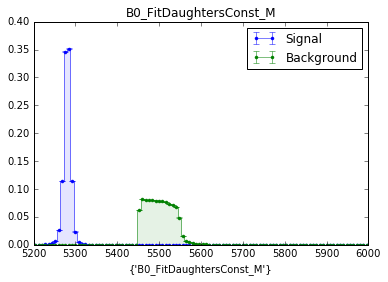

In [19]:
dataframe_names = ['Signal', 'Background']
plot_vars = ['B0_FitDaughtersConst_M']
plot_names = ['B0_FitDaughtersConst_M']
dataframe_list = [signal_dataframe, bkg_dataframe]
plotter = Plotter()
plotter.create_plots(dataframe_list, plot_vars, None, plot_names , dataframe_names)
plotter['B0_FitDaughtersConst_M'].set_range(5200, 6000)
p = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots')
plotter.plot()

Declare bdt features and correlation matrix and monte-carlo agreement
---------------------------------------------------------------------------------

In [20]:
bdt_features = [
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
#'B0_FitDaughtersConst_J_psi_1S_IP',   
#'B0_FitDaughtersConst_KS0_P1_PT',
#'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_min_PT',
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitPVConst_KS0_tau_dimless',
#'test_IP',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
#'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_min_PT'
]

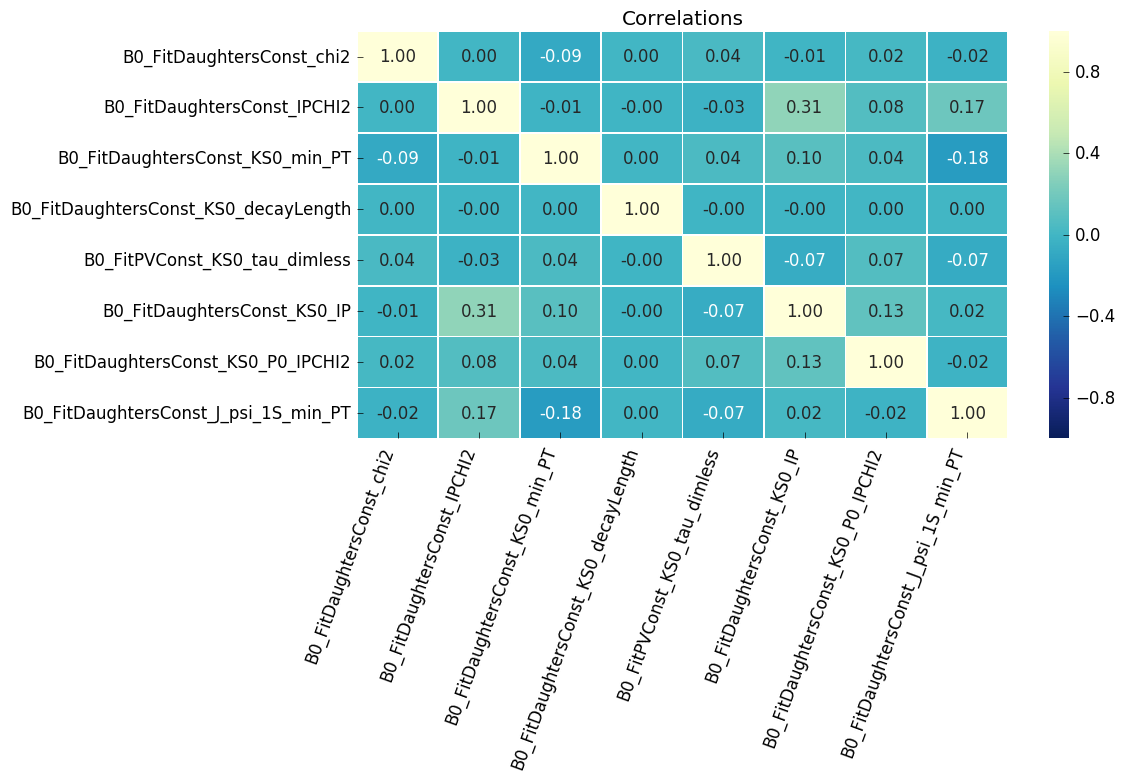

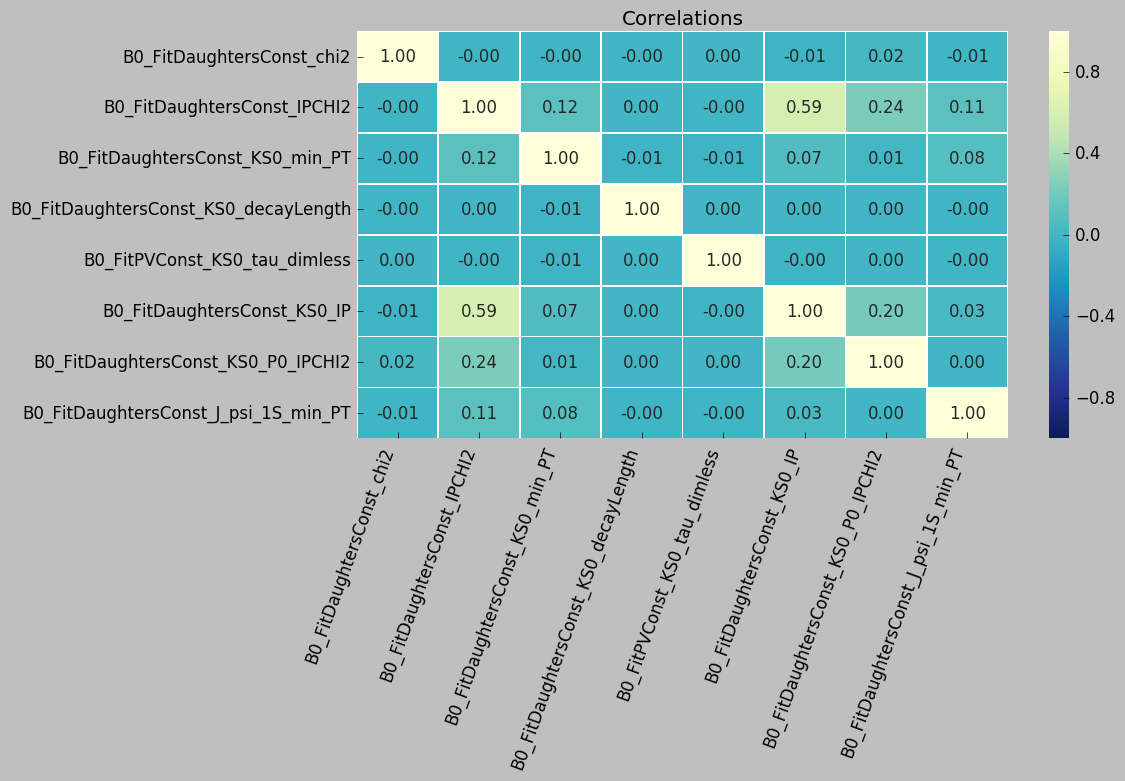

Done!


In [21]:
plt.figure(figsize=(12,8))
plot_correlations(bkg_dataframe[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/correlation_mc.png')
plt.show()
print('Done!')

Plot sWeighted BDT variables against MC
----------------------------------------------------------------------------------

In [22]:
'''#Check bdt-variables in downstream events
mc_weight = np.ones(signal_dataframe['B0_FitDaughtersConst_M'].count())
signal_dataframe['mc_weight'] = mc_weight
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/')
    plotter.create_plots([real_dataframe,signal_dataframe], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_dataframe[feature].quantile(0.95))
    #plotter[feature].set_range(0,20)
    plotter.plot()'''

"#Check bdt-variables in downstream events\nmc_weight = np.ones(signal_dataframe['B0_FitDaughtersConst_M'].count())\nsignal_dataframe['mc_weight'] = mc_weight\nfor feature in bdt_features:\n    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/')\n    plotter.create_plots([real_dataframe,signal_dataframe], feature, weightvars=['SigYield_sw','mc_weight']\n    ,component_labels=['sWeighted data','Signal-MC'])\n    plotter[feature].set_range(0,real_dataframe[feature].quantile(0.95))\n    #plotter[feature].set_range(0,20)\n    plotter.plot()"

Train GradienBoost classifier
====================================================================

In [23]:
flags = np.array([1]*len(signal_dataframe)+[0]*len(bkg_dataframe))
dataframe = pd.concat([signal_dataframe, bkg_dataframe])

In [24]:
signal_dataframe.shape, bkg_dataframe.shape,dataframe.shape

((594970, 27), (1047214, 30), (1642184, 31))

In [25]:
#Apply Track Type cuts piminus_TRACK_Type

In [26]:
train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(
                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)
classifier = GradientBoostingClassifier(max_depth=3, verbose=1,n_estimators=200,learning_rate=0.1)
classifier.fit(train_dataframe, train_flags)

      Iter       Train Loss   Remaining Time 
         1           1.2165           11.49m
         2           1.1418           11.35m
         3           1.0794           11.29m
         4           1.0263           11.06m
         5           0.9816           10.81m
         6           0.9414           10.58m
         7           0.9086           10.41m
         8           0.8787           10.25m
         9           0.8541           10.13m
        10           0.8314            9.99m
        20           0.6962            9.24m
        30           0.6306            8.73m
        40           0.5957            8.22m
        50           0.5725            7.80m
        60           0.5578            7.47m
        70           0.5482            7.00m
        80           0.5413            6.52m
        90           0.5357            6.03m
       100           0.5320            5.47m
       200           0.5131            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

In [27]:
dataframe.shape

(1642184, 31)

Classifier performance
-----------------------

In [28]:
classifier.score(test_dataframe, test_flags)

0.88979797635344149

In [29]:
importances = classifier.feature_importances_
print("Features sorted by their score:" )
importances_sorted = sorted(zip(importances, dataframe.columns), reverse=True)
for val,name in importances_sorted:
    print('{}: {:.4f}'.format(name, val))

Features sorted by their score:
B0_BKGCAT: 0.1915
B0_FitDaughtersConst_IPCHI2: 0.1746
B0_FitDaughtersConst_J_psi_1S_IPCHI2: 0.1665
B0_FitDaughtersConst_J_psi_1S_IP: 0.1230
B0_FitDaughtersConst_J_psi_1S_P1_PT: 0.1155
B0_FitDaughtersConst_KS0_IP: 0.0916
B0_FitDaughtersConst_J_psi_1S_min_PT: 0.0835
B0_FitDaughtersConst_J_psi_1S_P0_PT: 0.0537


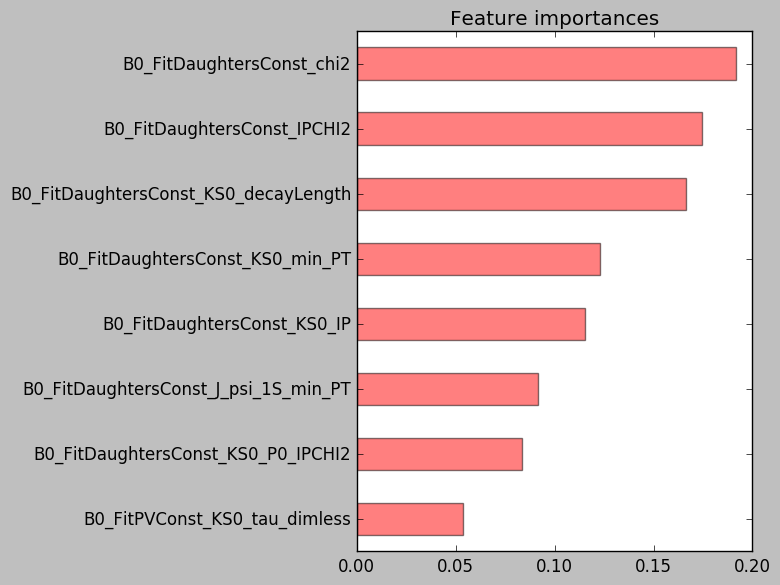

In [30]:
#Plot feature importances 
plot_feature_importances(classifier,dataframe[bdt_features])
plt.savefig('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/feature_importance.png', bbox_inches='tight')

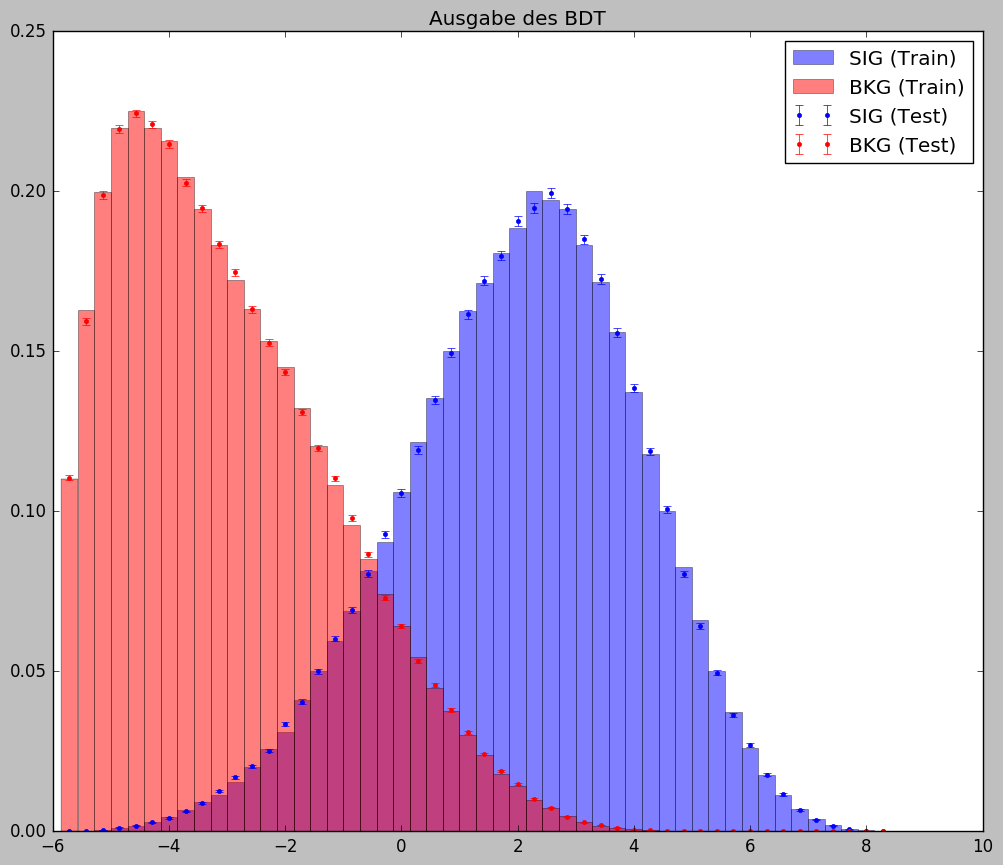

In [55]:
plt.figure(figsize=(12,10))
plot_classifier_output(classifier, train_dataframe, train_flags, test_dataframe, test_flags, title='Ausgabe des BDT',bins=50)
plt.savefig('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/overtraining.png')
plt.show()


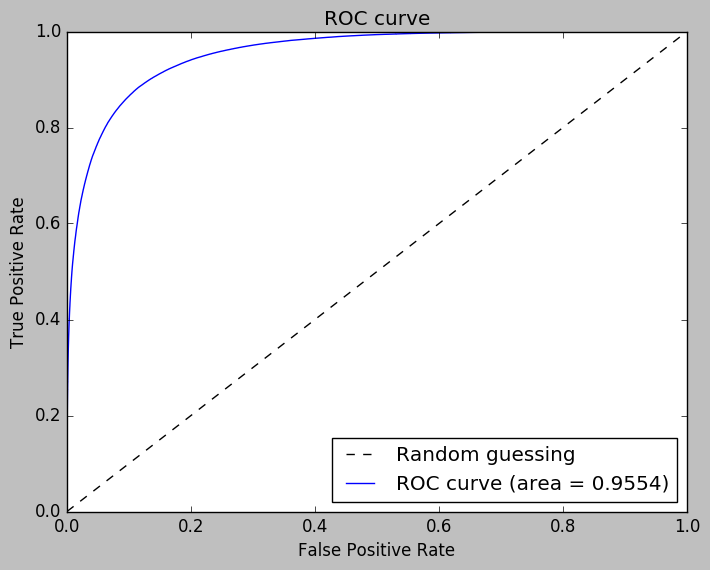

In [32]:
plot_roc_curve(classifier, test_dataframe, test_flags)
plt.savefig('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/roc_curve.png')




Classify unseen Data
============================================

In [33]:
unseen_df = real_dataframe
unseen_df.shape

(2523106, 31)

In [68]:
unseen_df.query('B0_FitDaughtersConst_M<5230').shape

(110641, 32)

In [66]:
unseen_df['B0_M'].min(axis=0)

5150.0415532296793

In [34]:
#apply classifier to data and MC
classify_unseen_data([classifier], real_dataframe, bdt_features, 'BDTresponse')
classify_unseen_data([classifier], signal_dataframe, bdt_features, 'BDTresponse')
classify_unseen_data([classifier], bkg_dataframe, bdt_features, 'BDTresponse')

In [35]:
real_dataframe

,B0_M,B0_TAGDECISION_OS,B0_TAGOMEGA_OS,B0_TAU,B0_TAUERR,B0_FitDaughtersConst_M,B0_FitDaughtersConst_chi2,B0_FitDaughtersConst_IPCHI2,B0_FitDaughtersConst_J_psi_1S_IP,B0_FitDaughtersConst_KS0_P1_PT,...,B0_FitDaughtersConst_J_psi_1S_P0_PT,B0_FitDaughtersConst_J_psi_1S_P1_PT,B0_FitPVConst_KS0_tau,B0_FitPVConst_KS0_tauErr,__array_index,B0_FitDaughtersConst_KS0_min_PT,test_IP,B0_FitDaughtersConst_J_psi_1S_min_PT,B0_FitPVConst_KS0_tau_dimless,BDTresponse
0,5358.216868,0,0.500000,0.001888,0.000051,5355.345215,26.257616,128.751755,0.130379,544.952942,...,521.928589,4603.533691,0.011053,0.000141,0,478.590851,1936.826416,521.928589,78.671333,-2.821940
1,5358.216868,0,0.500000,0.001888,0.000051,5355.345215,26.257616,3220.874023,0.915294,544.952942,...,521.928589,4603.533691,0.011496,0.000143,1,478.590851,1477.915039,521.928589,80.503784,-3.216729
2,5358.216868,0,0.500000,0.001888,0.000051,5355.345215,26.257616,7200.176758,3.028449,544.952942,...,521.928589,4603.533691,0.009979,0.000134,2,478.590851,5969.230957,521.928589,74.498260,-2.435941
3,5391.073733,0,0.500000,0.000704,0.000079,5391.084473,14.573977,4.135084,0.148750,1330.176392,...,2618.420166,758.134583,0.049223,0.001004,0,574.998413,304.620239,758.134583,49.042778,-1.690072
4,5391.073733,0,0.500000,0.000704,0.000079,5391.084473,14.573977,6.742537,0.122747,1330.176392,...,2618.420166,758.134583,0.049226,0.001004,1,574.998413,306.917267,758.134583,49.039410,-2.148219
5,5280.383698,0,0.500000,0.001683,0.000044,5275.218750,4.371940,0.277598,0.231093,1934.193726,...,1040.900146,1230.889893,0.081300,0.002163,0,959.028381,206.175705,1040.900146,37.591183,4.165635
6,5280.383698,0,0.500000,0.001683,0.000044,5275.218750,4.371940,7642.132324,0.651333,1934.193726,...,1040.900146,1230.889893,0.074437,0.002281,1,959.028381,54.873016,1040.900146,32.633247,1.322024
7,5280.383698,0,0.500000,0.001683,0.000044,5275.218750,4.371940,652.276367,0.077175,1934.193726,...,1040.900146,1230.889893,0.080458,0.002174,2,959.028381,144.895370,1040.900146,37.013340,0.914675
8,5273.540556,0,0.500000,0.004543,0.000071,5281.358398,8.704242,43.215881,0.444444,623.358154,...,2622.916504,2123.395996,0.201757,0.008471,0,440.564575,215.022324,2123.395996,23.817719,-2.026862
9,5273.540556,0,0.500000,0.004543,0.000071,5281.358398,8.704242,11369.760742,2.443795,623.358154,...,2622.916504,2123.395996,0.207009,0.008470,1,440.564575,210.733841,2123.395996,24.439276,-0.247341


In [36]:
np.where(pd.isnull(real_dataframe))

(array([], dtype=int64), array([], dtype=int64))

In [37]:
#Create new NTuple from dataframe 
#from root_pandas import to_root
#realdata_dataframe.to_root('/fhgfs/users/chasenberg/data/2015/jpsiks/Bd2JpsiKS_data_2015_flattened_BDTresponse.root',key='Bd2JspiKs')

Calculate simple FOM
---------------------------

In [38]:
bdt_cuts = np.linspace(-6,6,60)
fom_arr = []
for cut in bdt_cuts:
    nevents_after_bdt_dbkg = len(bkg_dataframe[bkg_dataframe['BDTresponse']>cut])
    nevents_after_bdt_signal = len(signal_dataframe[signal_dataframe['BDTresponse']>cut])
    fom = nevents_after_bdt_signal  / np.sqrt(nevents_after_bdt_dbkg+nevents_after_bdt_signal)
    fom_arr.append(fom)

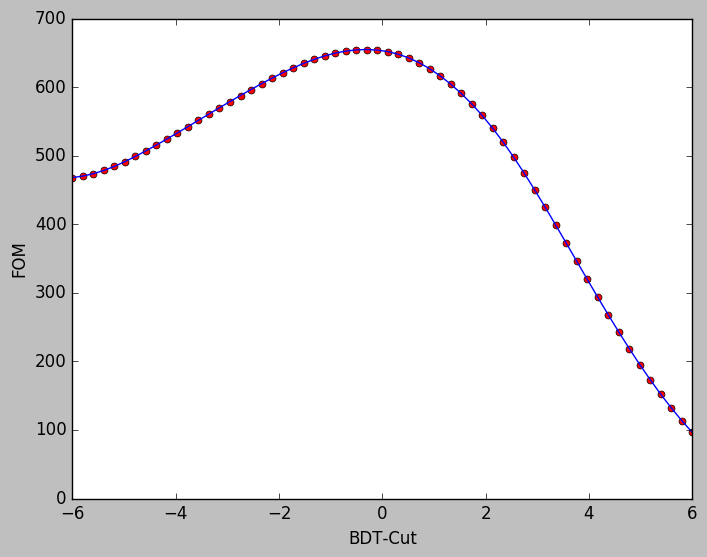

In [39]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(bdt_cuts, fom_arr,k=4, s=0)
spl.set_smoothing_factor(0.5)
plt.plot(bdt_cuts, fom_arr, 'ro', ms=5)
plt.plot(bdt_cuts,spl(bdt_cuts),'b')
plt.xlabel("BDT-Cut")
plt.ylabel("FOM")
plt.savefig('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/fom.png')

In [40]:
#Maximum of FOM
bdt_cut = spl.derivative().roots()[0]

In [41]:
bdt_cut

-0.32242016455925426

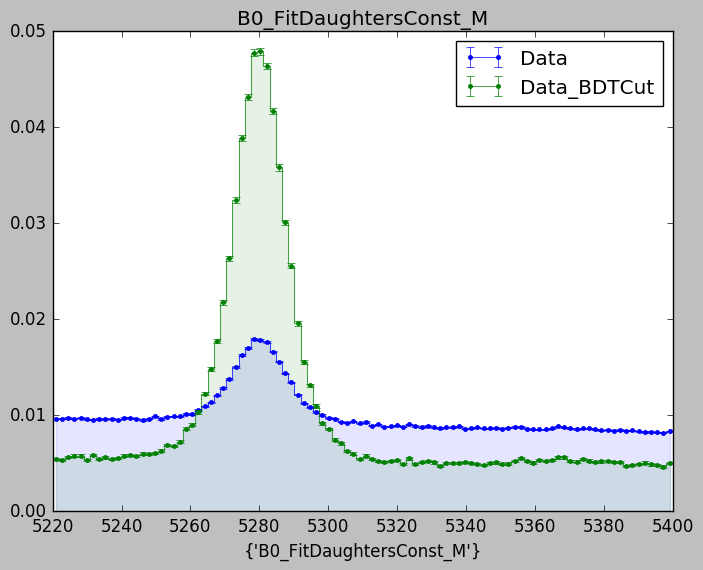

Efficiency of the cut: 0.16160518028176382
Number of Signalevents: 407747


In [42]:
#Plot realdata with bdt cuts 
test =  unseen_df[unseen_df['BDTresponse']>bdt_cut]
p = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/')
p.create_plots([unseen_df,test],'B0_FitDaughtersConst_M',component_labels=['Data','Data_BDTCut'])
p['B0_FitDaughtersConst_M'].set_range(5220, 5400)
#bdt_plot.plot()
p.plot()
efficiency = len(test) / len(real_dataframe)
n_sig = unseen_df[unseen_df['BDTresponse']>bdt_cut].shape[0]
print("Efficiency of the cut:",efficiency)
print("Number of Signalevents:",n_sig)

Compare data without triggerline requirements against selected data
-----------------------------------------------------------

In [43]:
test.shape,real_dataframe.shape,unseen_df.shape

((407747, 32), (2523106, 32), (2523106, 32))

In [44]:
#Write test-dataframe to root file 
unseen_df.to_root('/fhgfs/users/chasenberg/data/2015_2016/jpsiks/Bd2JpsiKS_data_2015_2016_flattened_BDTresponse.root',key='Bd2JpsiKs')

In [53]:
#Write test-dataframe to root filewtih bdt cut
unseen_df[unseen_df['BDTresponse']>-1.1].to_root('/fhgfs/users/chasenberg/data/2015_2016/jpsiks/Bd2JpsiKS_data_2015_2016_flattened_BDTresponse_cut.root',key='Bd2JpsiKs')

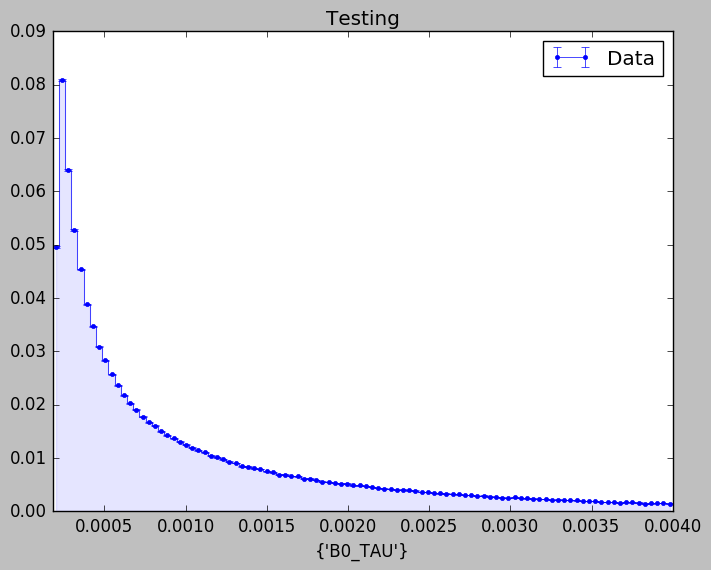

In [97]:
#Check bdt-output of training data vs. realdata bdt-output
p =Plotter('/home/chasenberg/plots/')
p.create_plots(unseen_df.query('B0_TAU>-0.0001&B0_TAU<0.004&BDTresponse'),'B0_TAU',component_labels=['Data'],plot_names=['Testing'])
#unseen_df.set_range(0,100)
p.plot()

Check efficiencies for bdt cut
=========================================

In [46]:
nevents_before_bdt = len(signal_dataframe)
print('ne£vents before BDT cut: ' + str(nevents_before_bdt))
nevents_after_bdt = len(signal_dataframe.query('BDTresponse>0.66'))
print('nevents after BDT cut: ' + str(nevents_after_bdt))
print('BDT signal efficiency: ' + str(nevents_after_bdt/nevents_before_bdt))

ne£vents before BDT cut: 594970
nevents after BDT cut: 448877
BDT signal efficiency: 0.7544531657058339


In [47]:
nevents_before_bdt = len(bkg_dataframe)
print('nevents before BDT cut: ' + str(nevents_before_bdt))
nevents_after_bdt = len(bkg_dataframe.query('BDTresponse>0.67'))
print('nevents after BDT cut: ' + str(nevents_after_bdt))
print('BDT background rejection: ' + str(1-nevents_after_bdt/nevents_before_bdt))

nevents before BDT cut: 1047214
nevents after BDT cut: 46513
BDT background rejection: 0.9555840544530535


Check BDT output
-------------------

In [48]:
'''#Check bdt-output of training data vs. realdata bdt-output
mc_weight = np.ones(signal_dataframe['B0_FitDaughtersConst_M'].count())
signal_dataframe['mc_weight'] = mc_weight
p =Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/')
p.create_plots([unseen_df,signal_dataframe],'BDTresponse',weightvars=['SigYield_sw','mc_weight'],component_labels=['Realdata BDT','Train BDT-Output'],plot_names=['BDTresponse'])
p['BDTresponse'].set_range(-10,15)
p.plot()'''

"#Check bdt-output of training data vs. realdata bdt-output\nmc_weight = np.ones(signal_dataframe['B0_FitDaughtersConst_M'].count())\nsignal_dataframe['mc_weight'] = mc_weight\np =Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/')\np.create_plots([unseen_df,signal_dataframe],'BDTresponse',weightvars=['SigYield_sw','mc_weight'],component_labels=['Realdata BDT','Train BDT-Output'],plot_names=['BDTresponse'])\np['BDTresponse'].set_range(-10,15)\np.plot()"

In [49]:
#Save signal MC with BDT Cut to ROOT File for Fitting Ipatia PDF
signal_cut = signal_dataframe.query('BDTresponse>0.63').sample(50000)
signal_cut.to_root('/fhgfs/users/chasenberg/mc/2016/jpsiks/dimuon/with_cut/Bd2JpsiKS_dimuon_mc_2016_flat_cuts_BDT_cut.root')

In [50]:
signal_cut.shape

(50000, 28)

In [51]:
#Save selected with BDT Cut to ROOT File for Fitting Ipatia PDF
data_cut_reduce = unseen_df.sample(100000)
data_cut_reduce.rename(columns={ 'SigYield_sw': 'sweight_sig','BkgYield_sw': 'sweight_bkg'}, inplace=True)
data_cut_reduce.to_root('/fhgfs/users/chasenberg/data/2015_2016/jpsiks/dimuon/with_cut/Bd2JpsiKS_dimuon_data_2015_2016_flat_BDT_cut_reduced.root',key='Bd2JpsiKs')

Check BDT Output of reduced data sample
------------------------------------------------